In [1]:
import requests, numpy as np, glob, matplotlib.pyplot as plt, os, tarfile
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from IPython.display import Image, display
import pdb

import warnings

# GROWTH Winter School 2018: detection rate of fast-moving asteroids

Authors: 
Quanzhi Ye (qye@caltech.edu)
Ashish Mahabal (ashish@caltech.edu)
Dmitry Duev (duev@caltech.edu)

In this module we will compute the detection rate of fast-moving asteroids. Fast-moving asteroids are asteroids that pass within ~20 lunar distances from Earth, and leave trails/streaks on astronomical images. One of the science goals of ZTF/GROWTH is to efficiently discover/follow-up such asteroids.

We will attack this problem in two steps:

1. Figure out which known asteroids will show up as streaks in ZTF images, and
2. Examine the streak catalog to see how many of them are detected.

There are only two steps. Sounds easy, but keep in mind that asteroids are a moving target, requiring good ephemerides. Also, orbits of different asteroids are known to different precision, leading to varying positional uncertainties.

## Step 1: fast-moving asteroids that fall on ZTF images

We will loop over the catalog of known NEAs (Near-Earth Asteroids) and make a series of queries to JPL's Horizon service and IPAC's IRSA service, to determine if and when they will be visible at Palomar (where ZTF runs from).

Let's download the catalog of known NEAs from the Minor Planet Center (MPC).

In [2]:
print('retrieving MPCORB...')
# mpcorb = 'https://www.minorplanetcenter.net/iau/MPCORB/NEA.txt'
# r = requests.get(mpcorb)
# mpcorb = r.text.split("\n")
mpcorb = open('NEA.txt','r').read().split("\n")
print('MPCORB file retrieved.')

retrieving MPCORB...
MPCORB file retrieved.


Now let us loop over the MPC catalog to check the visibility for every NEA. We will do it for NEA 2018 CL (the first NEA found by ZTF), and it's up to you to write a loop for it.

The format of the MPC catalog is described [here](https://www.minorplanetcenter.net/iau/info/MPOrbitFormat.html), it's best for machines but is somewhat human readable. First, we create an instance for the Horizons query. We only need to tell Horizons the name of the object we want to query, and the time window we want to query, and let Horizons do the heavy-lifting. Oh, and the three-letter-code for ZTF is I41, as described [here](https://www.minorplanetcenter.net/iau/lists/ObsCodesF.html). If the query returns zero entries, it means that the object is not observable at Palomar at the suggested time (interval).

First, let us define a time window we would like to query for. Our default is 20180205, the day ZTF science observations started:

In [21]:
start_date = '20180205'
end_date = '20180206'

Then let's do all the tasks described above. For now, we do our test with 2018 CL (the first NEA found by ZTF).
(in your local copy of astropy - astroquery/jplhorizons/__init__.py - you may have to make a change.
Replace http below with https:
'http://ssd.jpl.nasa.gov/horizons_batch.cgi',)

In [ ]:
def get_mpc_primary(inp):
    """ extract primary ID from an MPC-1 string parameter
    ---------
    input: MPC-1 data, strip of column 166-190
    """

    if inp[0:1] == '(':
        # (433) Eros
        return inp[inp.find("(")+1:inp.find(")")]
    else:
        # 2018 CL
        return inp

for i, obj in enumerate(mpcorb):
    obj_name = get_mpc_primary(obj[166:190].strip())
    if not obj_name == '2018 CL':
        continue
    else:
        break

obj = Horizons(id=obj_name, location='I41', \
                    epochs={'start': '{}-{}-{}'.format(start_date[0:4], start_date[4:6], start_date[6:8]), \
                   'stop': '{}-{}-{}'.format(end_date[0:4], end_date[4:6], end_date[6:8]), \
                   'step': '1h'})

eph = obj.ephemerides(skip_daylight=True, airmass_lessthan=5.0)
if len(eph) <= 0:
    print('object {} was not observable at Palomar'.format(obj_name))

We also want to calculate the motion of the asteroid to see if it will show up as a streak in our images.

In [5]:
rate = np.sqrt(eph['RA_rate']**2+eph['DEC_rate']**2)

Now, since we just discovered the power of JPL Horizons... why don't we take a short detour and do something fun? Let's say, we want to see the predicted trajectory of 2018 CL...

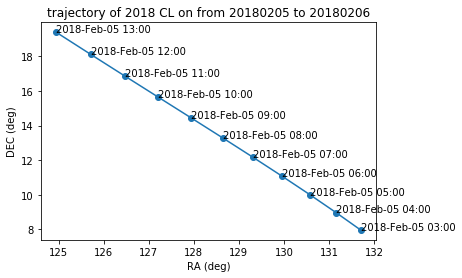

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(eph['RA'], eph['DEC'], 'o-')
ax.set_title('trajectory of 2018 CL on from %s to %s' % (start_date, end_date))
ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')

for i, xy in enumerate(zip(eph['RA'], eph['DEC'])):
    ax.annotate('%s' % eph['datetime_str'][i], xy=xy, textcoords='data')

plt.show()

What about the change of azimuth and elevation angle?

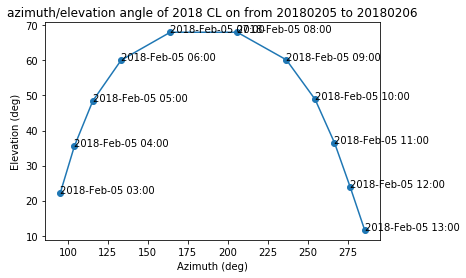

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(eph['AZ'], eph['EL'], 'o-')
ax.set_title('azimuth/elevation angle of 2018 CL on from %s to %s' % (start_date, end_date))
ax.set_xlabel('Azimuth (deg)')
ax.set_ylabel('Elevation (deg)')

for i, xy in enumerate(zip(eph['AZ'], eph['EL'])):
    ax.annotate('%s' % eph['datetime_str'][i], xy=xy, textcoords='data')

plt.show()

The complete lists of the values supported by `astroquery.jplhorizons` can be found [here](https://astroquery.readthedocs.io/en/latest/api/astroquery.jplhorizons.HorizonsClass.html#astroquery.jplhorizons.HorizonsClass.ephemerides). Play with it and be creative! For example, can you plot the change of RA/DEC rate over time? And what about the change of predicted V magnitude?

Now let's come back to our main journey. How fast does the asteroid need to be in order to show up as a streak? Let's take anything longer than 5 full-width-half-maximum (FWHM) as a streak. We know the exposure time of ZTF is 30 seconds, and the typical FWHM is 2''. Therefore, the minimum rate of motion is not too difficult to calculate:

In [8]:
min_rate = 2*5/30

print('minimum rate of motion for a streak: %.2f arcsec/sec.' %  min_rate)

minimum rate of motion for a streak: 0.33 arcsec/sec.


If the object will be a fast-mover at some point within the time window being queried, we will use IPAC's Moving Object Search Tool (MOST) to get a list of the images that the object is a fast-mover on them.

In [9]:
if max(rate) > min_rate:
    params = {'catalog': 'ztf', 'input_type': 'name_input', 'obj_name': '{}'.format(obj_name), \
              'obs_begin': '{}-{}-{}'.format(start_date[0:4], start_date[4:6], start_date[6:8]), \
              'obs_end': '{}-{}-{}'.format(end_date[0:4], end_date[4:6], end_date[6:8]), \
              'output_mode': 'Brief'}
    irsa_return = requests.get('https://irsa.ipac.caltech.edu/cgi-bin/MOST/nph-most', params=params)

...and MOST did give us something, right?

In [10]:
print(irsa_return.text)

\output_url = "https://irsa.ipac.caltech.edu:443/workspace/TMP_WXAY04_18615/MOST/pid18615"
\catalog = "ztf"
\user_input_begin_time = "2018-02-05"
\user_input_end_time = "2018-02-06"
\object_name = "(2018 CL)"
\element_epoch = "58154.0000   (2018-Feb-05 00:00:00.0000)"
\eccentricity = " 0.242496961324341"
\inclination = "11.987721695251381"
\argument_perihelion = "142.423969683856910"
\ascending_node = "136.338359646885010"
\semimajor_axis  =  " 0.851979508669249"
\mean_anomaly = "236.573041656847607"
\magnitude_parameters = "25.50  0.00" 
\job_time_stamp = "Fri Nov 30 06:11:40 2018"
\description = ZTF processed science image
\identifier  = ivo://irsa.ipac/ztf.sci
\notes       = ZTF science images
\datatype    = catalog
\archive     = IRSA
\set         = ZTF
\ generated at Thu Nov 29 08:00:01 PST 2018
\                                                                               
\fixlen = T
\ 
\ ra (deg) 
\ ___ Right ascension of image center
\ dec (deg) 
\ ___ Declination of image ce

Here is a loop over the query result from MOST to find out which images will contain the target as a fast-mover. Note that we want the predicted magnitude of the object to be <20 since that's the typical depth of ZTF.

In [11]:
limiting_magnitude = 20

We also make another query to Horizons to ensure the object is really a fast-mover in these dates. We do this as a double-check since Horizons produces most precise ephemerides for NEAs. Horizons also tell us what the expected positional uncertainty will be. Obviously, we don't want the positional uncertainty to be too big -- say, over 20".

In [12]:
max_unc = 20

And then we print out all the metadata that are potentially useful. We will just return the first entry (or it will be a very long entry!)

In [13]:
for ztf_entry in irsa_return.text.split("\n"):
    try:
        ztf_entry_vmag = float(ztf_entry[62:67])
    except:
        continue

    if ztf_entry_vmag < limiting_magnitude:
        ztf_entry_jd = float(ztf_entry[270:287])
        ztf_entry_pid = int(ztf_entry[185:199].strip())
        ztf_entry_fracday = int(ztf_entry[120:126].strip())
        ztf_entry_filefracday = int(ztf_entry[112:126].strip())
        ztf_entry_field = int(ztf_entry[135:139].strip())
        ztf_entry_filtercode = str(ztf_entry[173:177]).strip()
        ztf_entry_ccdid = int(ztf_entry[144:146].strip())
        ztf_entry_imgtypecode = str(ztf_entry[235:238]).strip()
        ztf_entry_qid = int(ztf_entry[150:152].strip())
        ztf_entry_sundist = float(ztf_entry[24:31])
        ztf_entry_geodist = float(ztf_entry[34:40])
        ztf_entry_dateUT = str(ztf_entry[112:120]).strip()
        
        obj_this = Horizons(id=obj_name, location='I41', epochs=ztf_entry_jd)
        eph = obj_this.ephemerides()
        ztf_entry_rate = np.sqrt(eph['RA_rate'][0]**2+eph['DEC_rate'][0]**2)

        if ztf_entry_rate > min_rate:
            ztf_entry_unc = np.sqrt(eph['RA_3sigma'][0]**2+eph['DEC_3sigma'][0]**2)

            if ztf_entry_unc < max_unc:
                print('hit: object {}'.format(obj_name))
                
                print('object name:', obj_name)
                print('image date (UT):', ztf_entry_dateUT)
                print('fracday:', ztf_entry_fracday)
                print('filter code:', ztf_entry_filtercode)
                print('distance to the Sun:', ztf_entry_sundist, 'AU')
                print('distance to the Earth:', ztf_entry_geodist, 'AU')
                print('predicted V magnitude:', ztf_entry_vmag)
                print('ecliptic latitude:', eph['ObsEclLat'][0])
                print('positional uncertainty: %.2f arcsec' % ztf_entry_unc)
                
                break

hit: object 2018 CL
object name: 2018 CL
image date (UT): 20180205
fracday: 231528
filter code: zr
distance to the Sun: 0.9936 AU
distance to the Earth: 0.0077 AU
predicted V magnitude: 15.69
ecliptic latitude: -7.4574757
positional uncertainty: 2.31 arcsec


Voila! You made it. Note that it takes quite a bit of time (a day or two) to loop over the entire NEA catalog -- this is because Horizons has to calculate the ephemerides for each of these ~15,000 NEAs and this is slow! Therefore, we provide a pre-generated result file for you to proceed to step 2. 

But do take a few known asteroids and see what you get for them. 

## Step 2: compare the catalog derived from step 1 to the source catalog generated by ZTF streak detection pipeline

Let's read in the result of step 1... (OK, we cheated, it is pre-generated)

In [14]:
check_fmo = np.genfromtxt('check_fmo.txt', dtype=None, \
                          delimiter=(12, 10, 6, 10, 10, 10, 5, 10, 10, 10), \
                         names=["object", "dateUT", "filter", "rate", "sundist", \
                                "geodist", "vmag", "ecllat", "unc", "fracday"])

C:\Users\Yashvi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


And also we read the source files from ZTF... essentially, these are a large number of "streak_qa" files, each file contains candidate streaks in one image. Apparently, we want to loop over them and see if there is any candidate that coincides the position of a known streaking NEA. We also record the rate and mag of detections and non-detections for diagnostic purpose.

For demonstrative purpose I am picking one of them to show you how this whole thing works. Let us start with our old friend, 2018 CL.

In [15]:
for cfi in check_fmo:
    if cfi[0].strip().decode('UTF8') == '2018 CL':
        break

What is the uncertainty range for this entry?

In [16]:
print(cfi[8], "arcsec")

2.3094 arcsec


This is very precise! Well, we know it should be small because the orbit from JPL has included ZTF observations.

Now, let's obtain the predicted coordinate for 2018 CL at this time, using the knowledge we just learned in Step 1.

In [17]:
expTimeJD = Time('{}-{}-{}'.format(str(cfi[1])[0:4], str(cfi[1])[4:6], str(cfi[1])[6:8]), format='iso').jd + float(cfi[9])/1000000

expTimeJD

2458154.731528

In [18]:
obj_this = Horizons(id=obj_name, location='I41', epochs=expTimeJD)
eph = obj_this.ephemerides()

eph

targetname,datetime_str,datetime_jd,H,G,solar_presence,flags,RA,DEC,RA_rate,DEC_rate,AZ,EL,airmass,magextinct,V,illumination,EclLon,EclLat,r,r_rate,delta,delta_rate,lighttime,elong,elongFlag,alpha,sunTargetPA,velocityPA,ObsEclLon,ObsEclLat,GlxLon,GlxLat,RA_3sigma,DEC_3sigma
---,---,d,mag,---,---,---,deg,deg,arcsec / h,arcsec / h,deg,deg,---,mag,mag,%,deg,deg,AU,km / s,AU,km / s,min,deg,---,deg,deg,deg,deg,deg,deg,deg,arcsec,arcsec
str9,str24,float64,float64,float64,str1,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,float64,float64
(2018 CL),2018-Feb-05 05:33:24.019,2458154.731527998,25.5,0.15,,,130.24304,10.59115,-2179.93,3843.943,124.2903,55.1746,1.217,0.21,15.55,99.291,136.0615,-0.0588,0.993552869965,-4.8924091,0.00768971056395,-5.5523857,0.063953,170.266,/T,9.6587,55.334,274.969,130.0804119,-7.4577146,215.728881,29.094296,1.32,1.895


A simplistic approach is to loop through each small folder generated by findStreaks and see if there is any candidate matching the predicted RA and DEC:

In [19]:
detectionRadius = 5/3600

In [57]:
d = sorted(glob.glob('{}/ztf*'.format('run-merged')))

targetRA = eph['RA'][0]
targetDec = eph['DEC'][0]

for di in d:
    fileName = os.path.basename(di)
    streaksQA_path = '{}/{}_streaksqa.txt'.format(di, fileName)
    
    if os.stat(streaksQA_path).st_size > 500:
        try:
            streaksQA = np.loadtxt(streaksQA_path, delimiter=',', comments='\\')
            for streaksQA_item in streaksQA:
                if (abs(streaksQA_item[1]-targetRA) < detectionRadius and \
                abs(streaksQA_item[2]-targetDec) < detectionRadius) or \
                (abs(streaksQA_item[3]-targetRA) < detectionRadius and \
                abs(streaksQA_item[4]-targetDec) < detectionRadius):
                        print('YES! Streak found in', streaksQA_path)
        except:
            continue

YES! Streak found in run-merged\ztf_20180205231528_000517_zr_c06_o_q4/ztf_20180205231528_000517_zr_c06_o_q4_streaksqa.txt


Wonderful! We have one hit! We can even take a look at the cutout to see what it looks like:

In [60]:
for di in d:
    fileName = os.path.basename(di)
            
    streaksQA_path = '{}/{}_streaksqa.txt'.format(di, fileName)
    
    if os.stat(streaksQA_path).st_size > 500:
        try:
            streaksQA = np.loadtxt(streaksQA_path, delimiter=',', comments='\\')
            for streaksQA_item in streaksQA:
                if (abs(streaksQA_item[1]-targetRA) < detectionRadius and \
                    abs(streaksQA_item[2]-targetDec) < detectionRadius) or \
                    (abs(streaksQA_item[3]-targetRA) < detectionRadius and \
                    abs(streaksQA_item[4]-targetDec) < detectionRadius):
                        folder_name = di.split('/')[-1]
                        jpgs = glob.glob('run-merged/' + folder_name + '/' + folder_name + '_cutouts/*.jpg')
                        display(Image(filename = jpgs[0], width=157, height=157))
        except:
            continue

Voila! Now, homework for you: can you use the example shown above to work out the detection efficiency of ZTF?